<h1><center>CANDIES tutorial for human skin data</center></h1>

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings

# read data
file_fold = 'E:/yan0/ours/CANDIES/data/human_skin' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_omics1_rna.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_omics2_adt.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
D:\anacon

In [2]:
adata_omics1

AnnData object with n_obs × n_vars = 1691 × 15486
    obs: 'slices_path'
    obsm: 'image_feat', 'image_feat_pca', 'spatial'

In [3]:
adata_omics2

AnnData object with n_obs × n_vars = 1691 × 283
    obs: 'slices_path'
    obsm: 'image_feat', 'image_feat_pca', 'spatial'

In [4]:
def run_leiden(adata1, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    adata = adata1.copy()
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata1.obs[key_added] = adata.obs["leiden"]
            
            return adata1
        
        this_step += 1
    
    print('Cannot find the number of clusters')
    adata1.obs[key_added] = adata.obs["leiden"]
    return adata1

In [5]:
from codes.DiTs import *
from codes.sampler import *
from codes.train_diff import *
from codes.ZINB_encoder import *
from codes.preprocess1 import *

E:\yan0\ours\CANDIES_code\tutorial
NVIDIA GeForce RTX 4060


## Data preprocessing

In [6]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

## Encoding phase

In [7]:
from codes.get_graph import construct_neighbor_graph,adjacent_matrix_preprocessing
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

adata_omics1, adata_omics2 = construct_neighbor_graph(adata_omics1, adata_omics2)

adj = adjacent_matrix_preprocessing(adata_omics1, adata_omics2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)

In [8]:
ae_model = encoder_ZINB(
    adata=adata_omics1,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    epochs=300, 
    dim_output=64
)

adata_omics1.obsm['emb_ZINB'], adj_mat = ae_model.train()

 11%|█         | 33/300 [00:00<00:05, 49.91it/s]

Early stop!
Optimization finished


In [9]:
seed = 2024
seed_everything(seed)

from codes.AutoEncoder import train_model
train_model(adata_omics1, adata_omics2, adj_spatial_omics1, adj_spatial_omics2, epochs=400)

Epoch [100/400], Loss RNA: 0.9362, Loss Protein: 0.6936
Epoch [200/400], Loss RNA: 0.8774, Loss Protein: 0.6131
Epoch [300/400], Loss RNA: 0.8519, Loss Protein: 0.5776
Epoch [400/400], Loss RNA: 0.8435, Loss Protein: 0.5586
Training complete!
Latent representations have been successfully added to adata_omics.obsm!


In [11]:
adata_omics1 = run_leiden(adata_omics1, n_cluster=10, use_rep="emb_ZINB", key_added="AE")
adata_omics2 = run_leiden(adata_omics2, n_cluster=10, use_rep="emb_latent_omics2", key_added="AE")

Succeed to find 10 clusters at resolution 1.031
Succeed to find 10 clusters at resolution 1.125


## Modality selcetion
The modality selcetion of CANDIES requires following input data: 
<br>
1. With annotation: cluster results of the two modality after encoding phase, and the annotation labels.
<br>
2. Without annotation: cluster results and the embeddings of the two modality after encoding phase.
<br>


In [14]:
from codes.modality_selection import modality_selection
modality_selection(adata_omics1.obs['AE'],adata_omics2.obs['AE'],modality1_embs=adata_omics1.obsm['emb_ZINB'],modality2_embs=adata_omics2.obsm['emb_latent_omics2'],spatial_coor=adata_omics1.obsm['spatial'])

We recommend you use modality 2 as condition in the denoise phase!


## Denoise phase
Before the diffusion process, we need to align the two modality embeddings according to the spatial coordinates.

In [15]:
import pandas as pd
import torch
import torch.nn as nn

ad2_ae = adata_omics2.obs['AE']
labels = torch.tensor(ad2_ae.values.astype(int), dtype=torch.long)
num_classes = labels.max().item() + 1 
embedding_layer = nn.Embedding(num_classes, 32)
label_embeddings = embedding_layer(labels).detach().numpy()
adata_omics2.obsm['label_embeddings_AE'] = label_embeddings

In [17]:
slices_omics1_spatial = adata_omics1.obsm['spatial']
slices_omics2_spatial = adata_omics2.obsm['spatial']

emb_latent_omics1 = adata_omics1.obsm['emb_ZINB']
emb_latent_omics2 = adata_omics2.obsm['label_embeddings_AE']

df_omics1 = pd.DataFrame(emb_latent_omics1, index=[tuple(coord) for coord in slices_omics1_spatial])
df_omics2 = pd.DataFrame(emb_latent_omics2, index=[tuple(coord) for coord in slices_omics2_spatial])

df_omics2_aligned = df_omics2.reindex(df_omics1.index)

aligned_emb_latent_omics1 = df_omics1.to_numpy()
aligned_emb_latent_omics2 = df_omics2_aligned.to_numpy()

print(aligned_emb_latent_omics1.shape)
print(aligned_emb_latent_omics2.shape)

(1691, 64)
(1691, 32)


In [18]:
aligned_emb_latent_omics1.std()

2.848515

In [19]:
aligned_emb_latent_omics2.std()

0.95399266

In [20]:
class ConditionalDiffusionDataset():
    def __init__(self, adata_omics1, adata_omics2):
        self.adata_omics1 = adata_omics1
        self.adata_omics2 = adata_omics2

        self.st_sample = torch.tensor(self.adata_omics1, dtype=torch.float32)
        self.con_sample = torch.tensor(self.adata_omics2, dtype=torch.float32)
        self.con_data = torch.tensor(self.adata_omics2, dtype=torch.float32)

    def __len__(self):
        return len(self.adata_omics1)

    def __getitem__(self, idx):
        return self.st_sample[idx], self.con_sample[idx], self.con_data

In [21]:
dataset = ConditionalDiffusionDataset(aligned_emb_latent_omics1, aligned_emb_latent_omics2) # denoise the first modality, condition on the second modality.

seed = 2024
seed_everything(seed)

com_mtx = run_diff(
    dataset,

    k=3,
    batch_size=512,
    hidden_size=256,
    learning_rate=1e-3,

    num_epoch=1000,
    diffusion_step=800,

    depth=6,
    head=16,
    pca_dim=50,

    device='cuda:0',
    classes=6,  
    patience=40,

    bias=0.5
)


*******************  Fold 1  (total 3 folds)  ********************


 23%|█████▋                   | 229/1000 [00:45<02:31,  5.08it/s, noise loss:0.4756924, lr:1.00e-05]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [00:48<00:00, 16.39it/s]  


*******************  Fold 2  (total 3 folds)  ********************


 27%|██████▊                  | 272/1000 [00:56<02:30,  4.84it/s, noise loss:0.4489170, lr:1.00e-05]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [00:50<00:00, 15.93it/s]  


*******************  Fold 3  (total 3 folds)  ********************


 27%|██████▊                  | 273/1000 [00:55<02:27,  4.94it/s, noise loss:0.4461539, lr:1.00e-05]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [00:52<00:00, 15.11it/s]  


In [22]:
adata_omics1.obsm['denoise_emb'] = com_mtx

## Integration phase

In [23]:
from codes.integration import *

In [24]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [25]:
spatial1 = pd.DataFrame(adata1.obsm['spatial'], columns=['x', 'y'])
spatial2 = pd.DataFrame(adata2.obsm['spatial'], columns=['x', 'y'])

spatial1['index1'] = spatial1.index
spatial2['index2'] = spatial2.index

merged = pd.merge(spatial1, spatial2, on=['x', 'y'], how='inner')

sorted_index1 = merged['index1'].values
sorted_index2 = merged['index2'].values

adata1 = adata1[sorted_index1]
adata2 = adata2[sorted_index2]

In [26]:
data_type = '10x'

adata1.obsm['feat'] = adata1.obsm['denoise_emb']
adata2.obsm['feat'] = adata2.obsm['emb_latent_omics2']

adata1, adata2 = construct_neighbor_graph(adata1, adata2)

In [27]:
adj = adjacent_matrix_preprocessing(adata1, adata2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
adj_feature_omics1 = adj['adj_feature_omics1'].to(device)
adj_feature_omics2 = adj['adj_feature_omics2'].to(device)

In [28]:
features_omics1 = torch.FloatTensor(adata1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata2.obsm['feat'].copy()).to(device)

seed = 2025
seed_everything(seed)

result = train_and_infer(
    features_omics1=features_omics1,
    features_omics2=features_omics2,
    adj_spatial_omics1=adj_spatial_omics1,
    adj_feature_omics1=adj_feature_omics1,
    adj_spatial_omics2=adj_spatial_omics2,
    adj_feature_omics2=adj_feature_omics2,
    device=device,
    epochs=200
)

Training Progress: 100%|██████████| 200/200 [00:40<00:00,  4.88it/s, Total Loss=15.3, Contrastive Loss (Spatial)=6.58, Contrastive Loss (Feature)=6.92, Reconstruction Loss 1=0.175, Reconstruction Loss 2=0.713, Reconstruction Loss 3=0.14, Reconstruction Loss 4=0.724] 


In [29]:
adata = adata1.copy()
adata.obsm['CANDIES'] = result['emb_latent_combined'].detach().cpu().numpy().copy()

## Visualization

In [35]:
adata = run_leiden(adata, n_cluster=10, use_rep="CANDIES", key_added="CANDIES")

Succeed to find 10 clusters at resolution 0.750


In [31]:
sc.pp.neighbors(adata, use_rep='CANDIES', n_neighbors=10)
sc.tl.umap(adata)

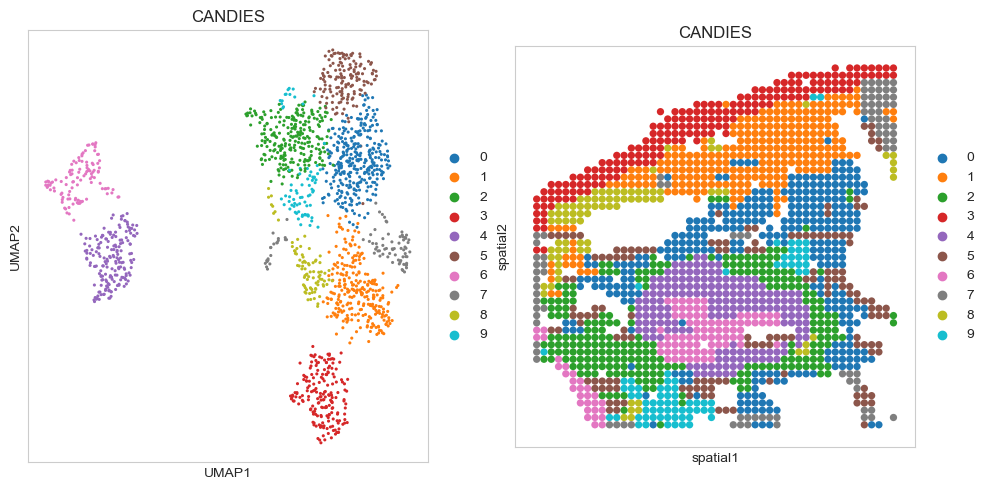

In [37]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(10,5))

sc.pl.umap(adata, color='CANDIES', ax=ax_list[0], title='CANDIES', s=20, show=False)
sc.pl.spatial(adata, img_key="hires", color=["CANDIES"],ax=ax_list[1], title=['CANDIES'], spot_size=1,show=False)

plt.tight_layout(w_pad=0.3)
plt.show()